In [1]:
import sys

import pandas as pd

sys.path.append("..")

import tsflex

print("using tsflex verion: ", tsflex.__version__)


using tsflex verion:  0.3.0


## Get the data

In [2]:
from tsflex.utils.data import load_empatica_data

df_tmp, df_acc, df_gsr, df_ibi = load_empatica_data(["tmp", "acc", "gsr", "ibi"])
data = [df_tmp, df_acc, df_gsr, df_ibi]


In [3]:
from pandas.tseries.frequencies import to_offset

for df in [df_tmp, df_acc, df_gsr, df_ibi]:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print(
            "Sampling rate:",
            1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(),
            "Hz\n",
        )
    except:
        print("Irregular sampling rate\n")


Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [4]:
# %pip install plotly kaleido
from plotly.subplots import make_subplots
import plotly.graph_objects as go


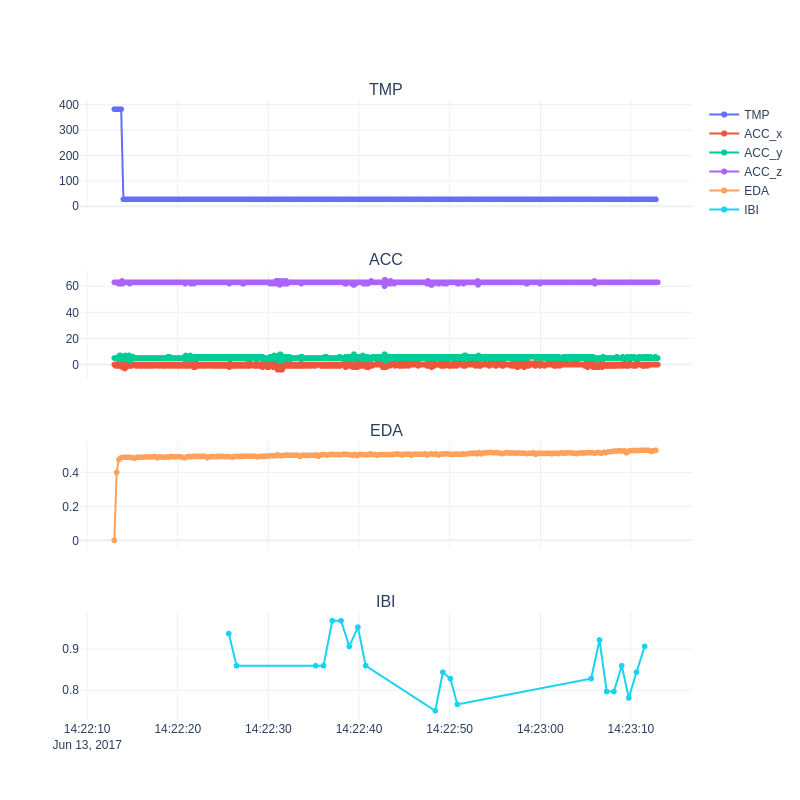

In [6]:
fig = make_subplots(
    rows=len(data),
    cols=1,
    shared_xaxes=True,
    subplot_titles=[df.columns.values[0].split("_")[0] for df in data],
    vertical_spacing=0.1,
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first("1min")
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(
                x=sub_df.index, y=sub_df[col].values, name=col, mode="lines+markers"
            ),
            row=plot_idx,
            col=1,
        )
fig.update_layout(template="plotly_white")
fig.show(renderer="png", height=len(data) * 200, width=800)


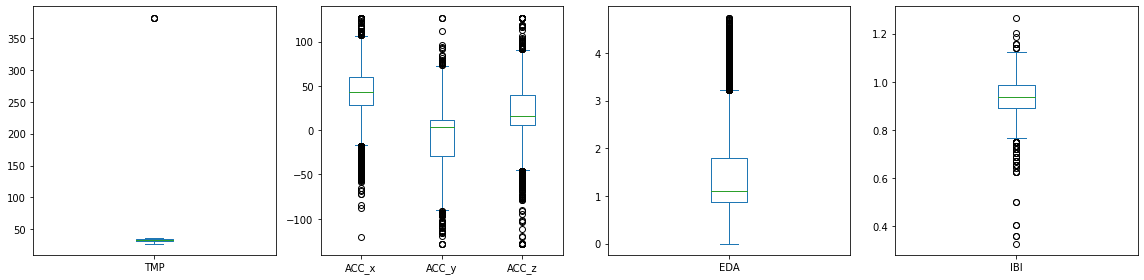

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for plot_idx, df in enumerate(data):
    df.plot(kind="box", ax=axes[plot_idx])
plt.tight_layout()


These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of [this paper notebook](https://github.com/predict-idlab/tsflex/blob/main/examples/tsflex_paper.ipynb)

In [8]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Create the processing functions
def clip_data(sig: pd.Series, min_val=None, max_val=None) -> np.ndarray:
    return np.clip(sig, a_min=min_val, a_max=max_val)


def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split("_")[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(
        result, index=sigs[0].index, name="|".join(sig_prefixes) + "_" + "SMV"
    )


# Create the series processors (with their keyword arguments)
tmp_clippper = SeriesProcessor(clip_data, series_names="TMP", max_val=35)
acc_savgol = SeriesProcessor(
    savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2
)
acc_smv = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline & process the data
series_pipe = SeriesPipeline([tmp_clippper, acc_savgol, acc_smv])
series_pipe


[
	clip_data {'max_val': 35} :  ('TMP',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [9]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])


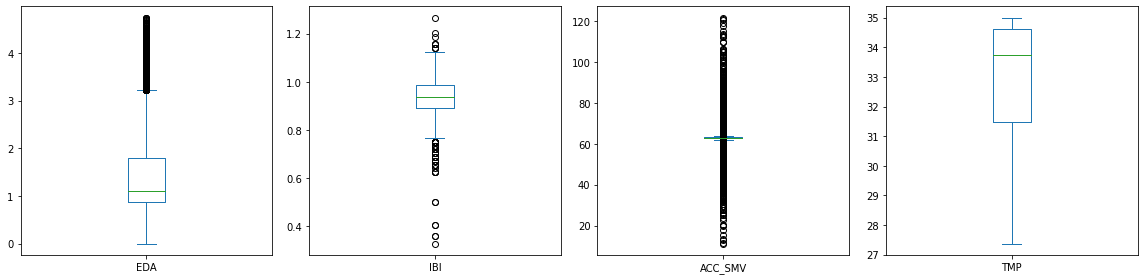

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind="box", ax=axes[plot_idx])
plt.tight_layout()


# tsflex feature extraction with [antropy](https://github.com/raphaelvallat/antropy) integration

In [11]:
# !pip install antropy


> Useful links;  
> [More detailed documentation of the antropy features](https://raphaelvallat.com/antropy/build/html/api.html)  

**<i>basic</i> `antropy` features**:  
Most `antropy` features are simple functions that return 1 value, and have no mandatory keyword arguments. As a result, they can be used directly in tsflex. However, if you want to change the default value of one of the keywords arguments, you can wrap the function in a `FuncWrapper` object. 

**<i>advanced</i> `antropy` features**:  
`antropy` features that should always be wrapped with a `FuncWrapper` are;
* `spectral_entropy` (because it requires the `fs` keyword argument)
* `hjorth_params` (because it returns 2 values)

In [12]:
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors


/home/jonas/.cache/pypoetry/virtualenvs/tsflex--QF-HHNX-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## Using basic antropy features

In [17]:
# %pip install antropy
import antropy as ant


In [18]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection

to_wrap_features = ["spectral_entropy", "hjorth_params"]

# All fractal features are "basic"
fractal_features = [getattr(ant, f) for f in ant.fractal.all]
# All entropy features are "basic" except for the ones that are in to_wrap_features
entropy_features = [
    getattr(ant, f) for f in ant.entropy.all if f not in to_wrap_features
]

basic_funcs = fractal_features  # + entropy_features

basic_feats = MultipleFeatureDescriptors(
    functions=basic_funcs,
    series_names=["ACC_SMV", "EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides="2min",
)
feature_collection = FeatureCollection(basic_feats)
feature_collection


ACC_SMV: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(higuchi_fd, ['higuchi_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(detrended_fluctuation, ['detrended_fluctuation'], {})    stride: ['2m'],
	]
	win: 2m30s : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(higuchi_fd, ['higuchi_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(detrended_fluctuation, ['detrended_fluctuation'], {})    stride: ['2m'],
	]
)
EDA: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(petrosian_fd, ['petrosian_fd'], {})    stride: ['2m'],
		FeatureDescriptor - func: FuncWrapper(katz_fd, ['katz_fd'], {

In [29]:
for data in out_data:
    data.values.flags.writeable = True


In [30]:
features_df = feature_collection.calculate(out_data, return_df=True, n_jobs=1)
features_df


Traceback (most recent call last):
  File "/home/jonas/git/github/tsflex/tsflex/features/feature_collection.py", line 632, in calculate
    calculated_feature_list = [self._executor(idx) for idx in idxs]
  File "/home/jonas/git/github/tsflex/tsflex/features/feature_collection.py", line 632, in <listcomp>
    calculated_feature_list = [self._executor(idx) for idx in idxs]
  File "/home/jonas/git/github/tsflex/tsflex/features/feature_collection.py", line 266, in _executor
    return stroll.apply_func(function)
  File "/home/jonas/git/github/tsflex/tsflex/features/segmenter/strided_rolling.py", line 450, in apply_func
    list(
  File "/home/jonas/git/github/tsflex/tsflex/features/function_wrapper.py", line 114, in __call__
    return self.func(*series, **self.kwargs)
  File "/home/jonas/.cache/pypoetry/virtualenvs/tsflex--QF-HHNX-py3.10/lib/python3.10/site-packages/antropy/fractal.py", line 446, in detrended_fluctuation
    return _dfa(x)
  File "/home/jonas/.cache/pypoetry/virtualenvs/t

RuntimeError: Feature Extraction halted due to error while extracting one (or multiple) feature(s)! See stack trace above.

### Plot the EDA features

In [21]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=["Raw EDA data", "EDA features"],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(
        x=df_gsr.index[:: 4 * 5],
        y=df_gsr["EDA"].values[:: 4 * 5],
        name="EDA",
        mode="markers",
    ),
    row=1,
    col=1,
)

ibi_feats = [c for c in features_df.columns if "EDA_" in c and "w=2m30s_" in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode="markers"),
        row=2,
        col=1,
    )

fig.update_layout(template="plotly_white")
fig.show(renderer="png", height=len(data) * 200, width=800)


NameError: name 'features_df' is not defined

## Using advanced features

In [31]:
# Import some "advanced" tsfel features
from tsfel.feature_extraction.features import (
    # Some temporal features
    calc_centroid,
    auc,
    entropy,
    neighbourhood_peaks,
    # Some statistical features
    hist,
    ecdf,
    ecdf_percentile_count,
    # Some spectral features
    spectral_distance,
    fundamental_frequency,
    max_power_spectrum,
    spectral_centroid,
    spectral_decrease,
    spectral_kurtosis,
    spectral_spread,
    human_range_energy,
    mfcc,
    fft_mean_coeff,
    wavelet_abs_mean,
    wavelet_std,
    wavelet_energy,
)


In [32]:
# Import all feature functions from seg-learn

from tsflex.features import FeatureCollection, MultipleFeatureDescriptors, FuncWrapper

advanced_feats = MultipleFeatureDescriptors(
    functions=[
        # Temporal
        FuncWrapper(calc_centroid, fs=4),
        FuncWrapper(auc, fs=4),
        FuncWrapper(entropy, prob="kde", output_names="entropy_kde"),
        FuncWrapper(entropy, prob="gauss", output_names="entropy_gauss"),
        FuncWrapper(neighbourhood_peaks, n=5, output_names="neighbourhood_peaks_n=5"),
        # Statistical
        FuncWrapper(hist, nbins=4, output_names=[f"hist{i}" for i in range(1, 5)]),
        FuncWrapper(ecdf, output_names=[f"ecdf{i}" for i in range(1, 11)]),
        FuncWrapper(ecdf_percentile_count, output_names=["ecdf_0.2", "ecdf_0.8"]),
        # Spectral
        FuncWrapper(spectral_distance, fs=4),
        FuncWrapper(fundamental_frequency, fs=4),
        FuncWrapper(max_power_spectrum, fs=4),
        FuncWrapper(spectral_centroid, fs=4),
        FuncWrapper(spectral_decrease, fs=4),
        FuncWrapper(spectral_kurtosis, fs=4),
        FuncWrapper(spectral_spread, fs=4),
        FuncWrapper(human_range_energy, fs=4),
        FuncWrapper(
            mfcc, fs=4, num_ceps=6, output_names=[f"mfcc{i}" for i in range(1, 7)]
        ),
        FuncWrapper(
            fft_mean_coeff,
            fs=4,
            nfreq=8,
            output_names=[f"fft_mean_coeff_{i}" for i in range(8)],
        ),
        FuncWrapper(
            wavelet_abs_mean,
            output_names=[f"wavelet_abs_mean_{i}" for i in range(1, 10)],
        ),
        FuncWrapper(
            wavelet_std, output_names=[f"wavelet_std_{i}" for i in range(1, 10)]
        ),
        FuncWrapper(
            wavelet_energy,
            widths=np.arange(1, 5),
            output_names=[f"wavelet_energy_{i}" for i in range(1, 5)],
        ),
    ],
    series_names=["EDA", "TMP"],
    windows=["5min", "2.5min"],
    strides=["2.5min"],
)
feature_collection = FeatureCollection(advanced_feats)
feature_collection


EDA: (
	win: 5m    : [
		FeatureDescriptor - func: FuncWrapper(calc_centroid, ['calc_centroid'], {'fs': 4})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(auc, ['auc'], {'fs': 4})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_kde'], {'prob': 'kde'})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(entropy, ['entropy_gauss'], {'prob': 'gauss'})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(neighbourhood_peaks, ['neighbourhood_peaks_n=5'], {'n': 5})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(hist, ['hist1', 'hist2', 'hist3', 'hist4'], {'nbins': 4})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(ecdf, ['ecdf1', 'ecdf2', 'ecdf3', 'ecdf4', 'ecdf5', 'ecdf6', 'ecdf7', 'ecdf8', 'ecdf9', 'ecdf10'], {})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(ecdf_percentile_count, ['ecdf_0.2', 'ecdf_0.8'], {})    stride: ['2m30s'],
		FeatureDescriptor - func: FuncWrapper(spectra

In [33]:
features_df = feature_collection.calculate(
    out_data, return_df=True, logging_file_path="tsfel_advanced.log"
)
features_df


,EDA__auc__w=2m30s,EDA__auc__w=5m,EDA__calc_centroid__w=2m30s,EDA__calc_centroid__w=5m,EDA__ecdf10__w=2m30s,EDA__ecdf10__w=5m,EDA__ecdf1__w=2m30s,EDA__ecdf1__w=5m,EDA__ecdf2__w=2m30s,EDA__ecdf2__w=5m,...,TMP__wavelet_std_5__w=2m30s,TMP__wavelet_std_5__w=5m,TMP__wavelet_std_6__w=2m30s,TMP__wavelet_std_6__w=5m,TMP__wavelet_std_7__w=2m30s,TMP__wavelet_std_7__w=5m,TMP__wavelet_std_8__w=2m30s,TMP__wavelet_std_8__w=5m,TMP__wavelet_std_9__w=2m30s,TMP__wavelet_std_9__w=5m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,82.461837,NaN,82.421866,NaN,0.016667,NaN,0.001667,NaN,0.003333,NaN,...,5.002295,NaN,5.841184,NaN,6.686805,NaN,7.535821,NaN,8.385133,NaN
2017-06-13 14:27:13+02:00,110.133445,192.741149,86.359785,182.039215,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.790044,3.638882,5.719857,4.260856,6.643068,4.889749,7.559655,5.523707,8.469133,6.160773
2017-06-13 14:29:43+02:00,125.093583,235.439719,72.334050,162.267442,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,4.937297,3.453637,5.897790,4.133228,6.850188,4.810630,7.793730,5.485410,8.728434,6.157382
2017-06-13 14:32:13+02:00,107.177666,232.470191,72.860379,135.431617,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.085715,3.597735,6.074760,4.306468,7.055956,5.012328,8.029210,5.714820,8.994736,6.413956
2017-06-13 14:34:43+02:00,120.859006,228.216110,79.609944,160.756980,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.287628,3.706909,6.315705,4.436043,7.336195,5.162769,8.348876,5.887268,9.353768,6.609739
2017-06-13 14:37:13+02:00,126.219086,247.297018,77.648459,157.409647,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.367532,3.757065,6.411893,4.497287,7.448961,5.235573,8.479117,5.972034,9.502458,6.706728
2017-06-13 14:39:43+02:00,136.526782,262.980798,77.413766,157.821477,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.378170,3.849494,6.422858,4.606399,7.458840,5.360261,8.486683,6.111283,9.506673,6.859552
2017-06-13 14:42:13+02:00,143.676892,280.456829,71.233357,152.823419,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.461435,3.892793,6.522403,4.658510,7.574513,5.420975,8.618698,6.180828,9.655310,6.938363
2017-06-13 14:44:43+02:00,119.428576,263.324091,74.143830,135.143790,0.016667,0.008333,0.001667,0.000833,0.003333,0.001667,...,5.524432,3.892039,6.597226,4.656987,7.661200,5.418797,8.716405,6.177796,9.762978,6.934192


### Plot the EDA features

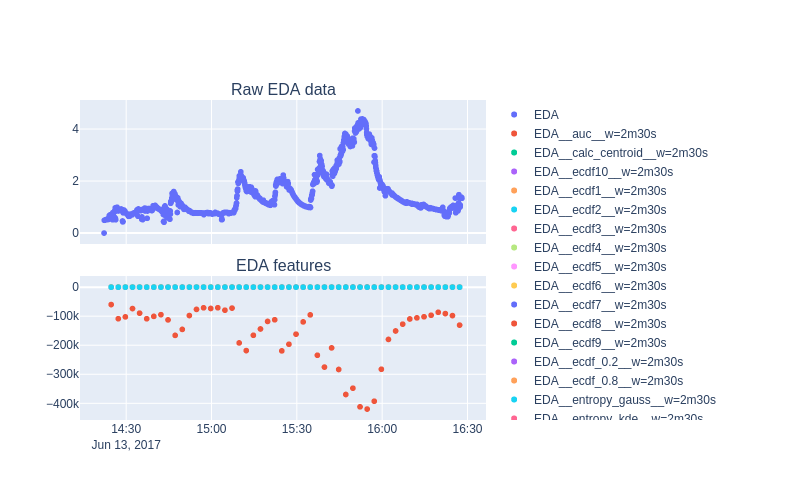

In [40]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    subplot_titles=["Raw EDA data", "EDA features"],
    vertical_spacing=0.1,
)

fig.add_trace(
    go.Scattergl(
        x=df_gsr.index[:: 4 * 5],
        y=df_gsr["EDA"].values[:: 4 * 5],
        name="EDA",
        mode="markers",
    ),
    row=1,
    col=1,
)

eda_feats = [c for c in features_df.columns if "EDA_" in c and "w=2m30s" in c]

for col in eda_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode="markers"),
        row=2,
        col=1,
    )

fig.update_layout(height=2 * 350)

fig.show(renderer="png", height=500, width=800)


### Analyze the logging results

In [41]:
from tsflex.features.logger import get_feature_logs

get_feature_logs(logging_file_path="tsfel_advanced.log")


,log_time,function,series_names,window,stride,output_names,duration,duration %
0,2023-02-02 19:10:20.571,calc_centroid,"(EDA,)",5m,"(2m30s,)",EDA__calc_centroid__w=5m,0 days 00:00:00.003723991,0.02
1,2023-02-02 19:10:20.571,auc,"(EDA,)",5m,"(2m30s,)",EDA__auc__w=5m,0 days 00:00:00.004055233,0.02
2,2023-02-02 19:10:20.582,ecdf,"(EDA,)",5m,"(2m30s,)","EDA__ecdf1__w=5m, EDA__ecdf2__w=5m, EDA__ecdf3...",0 days 00:00:00.009865111,0.06
3,2023-02-02 19:10:20.593,neighbourhood_peaks,"(EDA,)",5m,"(2m30s,)",EDA__neighbourhood_peaks_n=5__w=5m,0 days 00:00:00.021794897,0.12
4,2023-02-02 19:10:20.598,spectral_distance,"(EDA,)",5m,"(2m30s,)",EDA__spectral_distance__w=5m,0 days 00:00:00.020183233,0.11
...,...,...,...,...,...,...,...,...
79,2023-02-02 19:10:21.467,mfcc,"(TMP,)",2m30s,"(2m30s,)","TMP__mfcc1__w=2m30s, TMP__mfcc2__w=2m30s, TMP_...",0 days 00:00:00.223488961,1.25
80,2023-02-02 19:10:22.027,entropy,"(EDA,)",2m30s,"(2m30s,)",EDA__entropy_kde__w=2m30s,0 days 00:00:01.390901700,7.79
81,2023-02-02 19:10:22.209,entropy,"(TMP,)",2m30s,"(2m30s,)",TMP__entropy_kde__w=2m30s,0 days 00:00:01.145856380,6.42
82,2023-02-02 19:10:23.980,entropy,"(EDA,)",5m,"(2m30s,)",EDA__entropy_kde__w=5m,0 days 00:00:03.405032016,19.07


In [42]:
from tsflex.features.logger import get_function_stats

get_function_stats(logging_file_path="tsfel_advanced.log")


duration                            \
                                            sum      mean       std count   
function              window stride                                         
entropy               5m     (2m30s,)  7.259005  1.814751  1.862454     4   
                      2m30s  (2m30s,)  2.733712  0.683428  0.683289     4   
mfcc                  5m     (2m30s,)  1.049924  0.524962  0.176990     2   
                      2m30s  (2m30s,)  0.718381  0.359190  0.191911     2   
wavelet_std           5m     (2m30s,)  0.921385  0.460692  0.043379     2   
                      2m30s  (2m30s,)  0.345938  0.172969  0.000929     2   
wavelet_abs_mean      5m     (2m30s,)  0.830142  0.415071  0.070314     2   
                      2m30s  (2m30s,)  0.268807  0.134404  0.004403     2   
spectral_kurtosis     5m     (2m30s,)  0.513125  0.256563  0.022054     2   
                      2m30s  (2m30s,)  0.358281  0.179141  0.015070     2   
max_power_spectrum    5m     (2m30s,)  0.271896  0.135948  0.100873     2   
                      2m30s  (2m30s,)  0.399538  0.199769  0.034855     2   
wavelet_energy        5m     (2m30s,)  0.188004  0.094002  0.035669     2   
                      2m30s  (2m30s,)  0.272588  0.136294  0.010796     2   
fft_mean_coeff        5m     (2m30s,)  0.152358  0.076179  0.019055     2   
                      2m30s  (2m30s,)  0.187499  0.093750  0.014801     2   
human_range_energy    5m     (2m30s,)  0.127053  0.063527  0.014516     2   
                      2m30s  (2m30s,)  0.062072  0.031036  0.009449     2   
spectral_decrease     5m     (2m30s,)  0.102967  0.051484  0.050622     2   
                      2m30s  (2m30s,)  0.080910  0.040455  0.022798     2   
neighbourhood_peaks   5m     (2m30s,)  0.092202  0.046101  0.034374     2   
                      2m30s  (2m30s,)  0.085443  0.042722  0.009678     2   
hist                  5m     (2m30s,)  0.051783  0.025892  0.003036     2   
                      2m30s  (2m30s,)  0.115846  0.057923  0.013795     2   
spectral_spread       5m     (2m30s,)  0.107652  0.053826  0.020916     2   
                      2m30s  (2m30s,)  0.052107  0.026054  0.010875     2   
fundamental_frequency 5m     (2m30s,)  0.066253  0.033127  0.006402     2   
                      2m30s  (2m30s,)  0.052925  0.026463  0.001396     2   
spectral_distance     5m     (2m30s,)  0.033730  0.016865  0.004693     2   
                      2m30s  (2m30s,)  0.071792  0.035896  0.000051     2   
ecdf_percentile_count 5m     (2m30s,)  0.050151  0.025075  0.023278     2   
                      2m30s  (2m30s,)  0.037179  0.018590  0.006341     2   
spectral_centroid     5m     (2m30s,)  0.040607  0.020304  0.008626     2   
                      2m30s  (2m30s,)  0.040759  0.020379  0.004760     2   
auc                   5m     (2m30s,)  0.048809  0.024404  0.028778     2   
                      2m30s  (2m30s,)  0.006461  0.003230  0.000366     2   
calc_centroid         5m     (2m30s,)  0.026779  0.013389  0.013669     2   
                      2m30s  (2m30s,)  0.005274  0.002637  0.000163     2   
ecdf                  5m     (2m30s,)  0.014429  0.007215  0.003748     2   
                      2m30s  (2m30s,)  0.011402  0.005701  0.004092     2   

                                      duration %           
                                             sum     mean  
function              window stride                        
entropy               5m     (2m30s,)      40.65  10.1625  
                      2m30s  (2m30s,)      15.32   3.8300  
mfcc                  5m     (2m30s,)       5.88   2.9400  
                      2m30s  (2m30s,)       4.02   2.0100  
wavelet_std           5m     (2m30s,)       5.16   2.5800  
                      2m30s  (2m30s,)       1.94   0.9700  
wavelet_abs_mean      5m     (2m30s,)       4.65   2.3250  
                      2m30s  (2m30s,)       1.51   0.7550  
spectral_kurtosis     5m     (2m30s,)       2.87   1.4350  
       

It is now obvious that the `entropy` function takes the main chunk of the feature extraction time and does not scale to larger window sizes.

In [43]:
from tsflex.features.logger import get_series_names_stats

get_series_names_stats(logging_file_path="tsfel_advanced.log")


duration                           duration %  \
                                   sum      mean       std count        sum   
series_names window stride                                                    
(EDA,)       5m     (2m30s,)  6.222857  0.296327  0.736379    21      34.84   
(TMP,)       5m     (2m30s,)  5.725397  0.272638  0.739438    21      32.07   
(EDA,)       2m30s  (2m30s,)  3.196568  0.152218  0.305493    21      17.92   
(TMP,)       2m30s  (2m30s,)  2.710347  0.129064  0.243003    21      15.19   

                                        
                                  mean  
series_names window stride              
(EDA,)       5m     (2m30s,)  1.659048  
(TMP,)       5m     (2m30s,)  1.527143  
(EDA,)       2m30s  (2m30s,)  0.853333  
(TMP,)       2m30s  (2m30s,)  0.723333

In general, feature calculation on the `5m` window takes more than twice as long as on the `2m30s` window